# Análisis estadístico de goles en Mundiales FIFA: ¿Quién anota más, hombres o mujeres?

![A soccer pitch for an international match.](soccer-pitch.jpg)

### *TL;DR: Se comparó la cantidad de goles en partidos internacionales masculinos y femeninos desde 2002. Los análisis muestran que, en promedio, las mujeres anotan más goles por partido que los hombres.*


### La pregunta que me hice 
¿Existen diferencias significativas en la cantidad de goles anotados por partido entre los equipos masculinos y femeninos en los Mundiales FIFA?

Quise responderlo con evidencia estadística, usando tests que comparen dos grupos independientes.

Después de años de seguir de cerca el fútbol masculino y con la fuerte introducción del fútbol femenino en el plano profesional, mi instinto decía que los encuentros femeninos suelen tener más goles que los masculinos. Sin embargo, lo que era simplemente una sensación tenía que ser confirmado con datos y un test estadístico válido. 

Para acotar el análisis y la variabilidad de rendimientos a lo largo de los años y diferentes torneos, se han seleccionado únicamente los partidos oficiales de la Copa Mundial de la FIFA desde el año 2002. 

Para esto, se partió de la base que contienen todos los resultados de los partidos internacionales oficiales masculinos y femeninos desde el año 1900. La pregunta que se quiere responder es clara: 

**¿Se anotan más goles en los partidos internacionales femeninos que en los masculinos?**

Para abordarlo de forma rigurosa, establecí un nivel de significancia del 10% y formulé las hipótesis: 

$H_0$ : El promedio de goles por partido en los encuentros femeninos es igual al de los masculinos.

$H_A$ : El promedio de goles por partido en los encuentros femeninos es mayor que el de los masculinos.

### Paso 1 - Preparar los datos

Antes de lanzarnos al análisis, debemos entender cómo están organizados los datos, qué información tenemos disponible y si hay algún detalle que deba ser limpiado o ajustado. 
Primero, importamos las librerías esenciales: 
- `pandas` para manipular los datos y explorar los resultados de cada partido.
- `matplotlib.pyplot` para **visualizar los datos** mediante histogramas y detectar patrones a simple vista.
- `pingouin` para aplicar el **test de Mann–Whitney U**, que nos va a ayudar a comparar los goles femeninos y masculinos sin asumir una distribución normal.
- `scipy.stats.ttest_ind` para aplicar el **t-test**, útil si la distribución resulta suficientemente aproximada a la normal.
- Además, definimos `alpha = 0.1` como nuestro **nivel de significancia**, la regla que nos permitirá decidir si hay evidencia estadística para respaldar nuestra intuición.

Luego, cargamos los datasets de resultados masculinos y femeninos en dataframes de pandas, asegurándonos que cada columna tenga el tipo de dato que corresponde.
Finalmente, se echa un primer vistazo a la información con `.info()`. Acá se busca entender:
- Qué columnas tenemos (equipos, goles, torneo, fecha, etc.).
- Si hay valores nulos o inconsistentes que puedan afectar el análisis.
- La cantidad de registros, que nos dará una idea del tamaño de la muestra con la que trabajaremos.

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import pingouin 
from scipy.stats import ttest_ind 
alpha = 0.1 

men_results = pd.read_csv('men_results.csv', parse_dates=['date'])
women_results = pd.read_csv('women_results.csv', parse_dates=['date'])

men_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44353 entries, 0 to 44352
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  44353 non-null  int64         
 1   date        44353 non-null  datetime64[ns]
 2   home_team   44353 non-null  object        
 3   away_team   44353 non-null  object        
 4   home_score  44353 non-null  int64         
 5   away_score  44353 non-null  int64         
 6   tournament  44353 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.4+ MB


### Paso 2 - Filtrar los datos relevantes

Ahora que conocemos cómo están estructurados los datasets, es momento de enfocarnos en lo que realmente nos interesa: los partidos por Copa Mundial de FIFA desde 2002.
Para ello, se aplica un filtro doble: 
1. Que la fecha del partido sea posterior al 1 de enero de 2002, asegurándonos de analizar solo datos recientes y comparables.
2. Que el torneo sea **FIFA World Cup**, dejando afuera amistosos, torneos continentales o fases de clasificación.
Esto nos permite concentrarnos únicamente en los encuentros importantes y representativos, evitando ruido que pueda distorsionar nuestras conclusiones. A continuación, visualizamos las primeras 10 filas de los datasets filtrados para ver cómo se estructura la información después de ser filtrada.


In [ ]:
men_results = men_results[(men_results['date']> '2002-01-01') & (men_results['tournament'] == 'FIFA World Cup')] 
women_results = women_results[(women_results['date']> '2002-01-01') & (women_results['tournament'] == 'FIFA World Cup')] 

men_results.head(10)

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
25164,25164,2002-05-31,France,Senegal,0,1,FIFA World Cup
25165,25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup
25166,25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup
25167,25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup
25168,25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup
25169,25169,2002-06-02,England,Sweden,1,1,FIFA World Cup
25170,25170,2002-06-02,Paraguay,South Africa,2,2,FIFA World Cup
25171,25171,2002-06-02,Spain,Slovenia,3,1,FIFA World Cup
25172,25172,2002-06-03,Brazil,Turkey,2,1,FIFA World Cup
25173,25173,2002-06-03,Croatia,Mexico,0,1,FIFA World Cup


Hasta ahora, tenemos los goles de cada equipo por separado: **home_score** y **away_score**. 

Pero nuestra pregunta central es **cuántos goles se anotan en total por partido**, independientemente de qué equipo los marcó.  

Por eso, creamos una nueva columna `total_goals` que suma los goles del local y del visitante en cada encuentro. Esta columna será la base para todos los análisis posteriores, desde histogramas hasta los tests estadísticos. Para asegurarnos de que todo salió bien, visualizamos las primeras filas del dataset filtrado con esta nueva columna.

In [ ]:
men_results['total_goals'] = men_results['home_score'] + men_results['away_score']
women_results['total_goals'] = women_results['home_score'] + women_results['away_score']

men_results.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,total_goals
25164,25164,2002-05-31,France,Senegal,0,1,FIFA World Cup,1
25165,25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,8
25166,25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,2
25167,25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,3
25168,25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,1


Antes de visualizar los goles por partido, necesitamos entender la distribución de los datos.  
Con `.describe()`, obtenemos estadísticas clave como:

- El **valor máximo de goles por partido**, que nos ayudará a definir los `bins` del histograma. Estos serán los intervalos en los que se dividen los datos para mostrar cuántos partidos hubo con cada cantidad de goles. 
- Promedios, medianas y cuartiles, que nos dan una idea de cómo se comportan los goles en general.  

Esta información será importante para elegir un rango adecuado en los gráficos, de manera que las visualizaciones reflejen fielmente las estadísticas de los partidos sin perder detalles.

In [ ]:
men_results.describe()
women_results.describe()

,Unnamed: 0,home_score,away_score,total_goals
count,200.000000,200.000000,200.000000,200.000000
mean,3094.485000,1.805000,1.175000,2.980000
std,1010.682192,1.937977,1.289453,2.022387
min,1600.000000,0.000000,0.000000,0.000000
25%,2155.750000,1.000000,0.000000,2.000000
50%,3429.500000,1.000000,1.000000,3.000000
75%,4418.250000,2.000000,2.000000,4.000000
max,4469.000000,13.000000,7.000000,13.000000


### Paso 3 - Análisis de distribuciones y tests paramétricos y no paramétricos

Para entender la forma en que se distribuyen los goles, el siguiente paso fue visualizar ambos conjuntos de datos en un histograma. Elegimos un rango de bins que va de 0 a 13 goles —suficiente para cubrir todos los valores posibles— y superpusimos los histogramas de hombres y mujeres para compararlos fácilmente.

Si bien las distribuciones no son perfectamente simétricas (algo esperable en datos de goles, que suelen ser bajos y discretos), la cantidad de partidos disponibles es lo suficientemente grande (n≈200 para mujeres y n≈380 para hombres) como para considerar que un test paramétrico podría funcionar de forma robusta. Aun así, esta visualización nos recuerda que es útil complementar el análisis con pruebas no paramétricas.

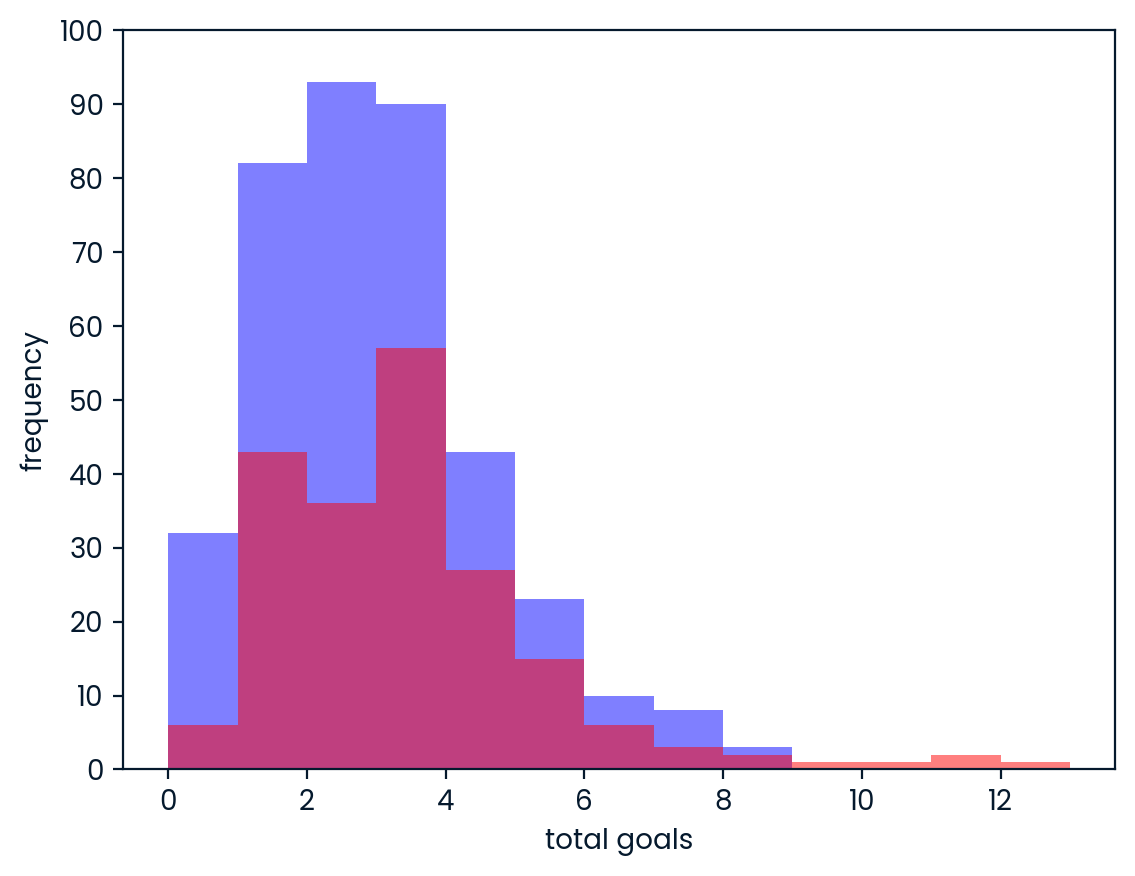

In [ ]:
bins = range(0,14)
plt.hist(men_results['total_goals'], bins= bins, alpha=0.5, color='blue')
plt.hist(women_results['total_goals'], bins= bins, alpha=0.5, color='red')
plt.xlabel('total goals')
plt.ylabel('frequency')
plt.yticks(range(0,101,10))
plt.show()

Aunque el histograma muestra una distribución algo asimétrica, contamos con un tamaño muestral grande en ambos casos, lo que permite aplicar un t-test de forma robusta.
Sin embargo, como los goles son datos discretos y no estrictamente normales, decidimos complementar el análisis con una prueba no paramétrica, específicamente el Mann–Whitney U (`.mwu()`), que no asume normalidad y compara directamente las distribuciones.

In [ ]:
results = pingouin.mwu(x=women_results['total_goals'], y=men_results['total_goals'], alternative='greater')
p_val_mwu = results['p-val'].iloc[0] 
p_val_mwu = float(p_val_mwu)
print('p_val: ', p_val_mwu)
print('alpha: ', alpha)

if p_val_mwu < alpha:
    print('Reject the null hypothesis with an alpha of 0.1')
else:
    print('Fail to reject the null hypothesis with an alpha of 0.1')

p_val:  0.005106609825443641
alpha:  0.1
Reject the null hypothesis with an alpha of 0.1


Como para el test Mann-Whitney U p-value < alpha, se rechaza la hipótesis nula para un nivel de significancia del 10%. 

Entonces, como rechazamos la hipótesis nula, se concluye que **las mujeres anotan más goles por partido que los hombres**, según este dataset y con un 90% de confianza.

A continuación, se estudiará el mismo dataset con la misma consigna, pero bajo las condiciones de un t-test que sí asume normalidad. 

In [ ]:
t_stat, p_val_ttest = ttest_ind(
    women_results['total_goals'], 
    men_results['total_goals'], 
    equal_var=False, # Asumimos que las varianzas no son iguales (Welch's Test) 
    alternative='greater')

print('p_val: ', p_val_ttest)
print('alpha: ', alpha)

if p_val_ttest < alpha:
    print('Reject the null hypothesis with an alpha of 0.1')
else:
    print('Fail to reject the null hypothesis with an alpha of 0.1')

p_val:  0.0025980724004871503
alpha:  0.1
Reject the null hypothesis with an alpha of 0.1


Como para el Welch's t-test (distribución normal con varianzas diferentes) el p_value < alpha, se rechaza la hipótesis nula para un nivel de significancia del 10%.
Entonces, como rechazamos la hipótesis nula, **las mujeres anotan más goles por partido que los hombres**, según este dataset y con un 90% de confianza.

# Conclusión

El análisis estadístico confirmó lo que durante años parecía apenas una corazonada periodística: los partidos internacionales femeninos presentan, en promedio, más goles que los masculinos.
Tanto la prueba paramétrica (t-test) como la no paramétrica (Mann–Whitney U) coincidieron en el mismo veredicto: el valor-p fue menor que nuestro nivel de significancia del 10%, por lo que rechazamos la hipótesis nula.

En términos simples:
- Según los datos de los Mundiales FIFA desde 2002, los partidos femeninos tienden a tener mayor cantidad de goles.



<div style="border-left: 4px solid #4F8DF5; padding: 0.8rem 1rem; margin-top: 2rem;">
📌 Autor del análisis

Francisco Ara — Sports Data Analyst & Football Scout

Podés contactarme por correo electrónico a ffranciscoara@gmail.com ✉️

Podés ver mi perfil en [LinkedIn](https://www.linkedin.com/in/francisco-ara/) 🔗


O mi [Portfolio Personal](https://sites.google.com/view/franciscoara/espa%C3%B1ol) 💼


</div>